<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#006a79; font-size:40px'> 
Credit Risk Analysis using Deep Learning
</h1>

<h5 style='margin:15px 15px; color:#006a79; '> 
Modeling and Searching Baseline
</h5>
</div>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>
1.Sklearn Classifier Models
</h2>
</div>

<div class="alert alert-info" style="background-color:#63A6A2; color:white; padding:0px 10px; border-radius:5px;">
<h5 style='margin:10px 5px'>
1.1. Import the Libraries
</h5>
</div>

In [5]:

import os
import sys
from pathlib import Path
sys.path.append(str(Path('/home/fedecano/AnyoneAI/proyecto-final-anyoneai/scripts/evaluation.py').parent.parent))

import joblib
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from lightgbm import LGBMClassifier
import xgboost as xgb
from scripts import evaluation
import warnings
warnings.filterwarnings('ignore')
SEED = 1 # GLOBAL CONSTANTS


<div class="alert alert-info" style="background-color:#63A6A2; color:white; padding:0px 10px; border-radius:5px;">
<h5 style='margin:10px 5px'>
1.2. Load the datasets
</h5>
</div>

In [6]:
# Read training data
X_train = pd.read_csv('../data/X_train.csv', index_col=0)
X_test = pd.read_csv('../data/X_test.csv', index_col=0)
X_val = pd.read_csv('../data/X_val.csv', index_col=0)
y_train = pd.read_csv('../data/y_train.csv', index_col=0)
y_test = pd.read_csv('../data/y_test.csv', index_col=0)
y_val = pd.read_csv('../data/y_val.csv', index_col=0)

<div class="alert alert-info" style="background-color:#63A6A2; color:white; padding:0px 10px; border-radius:5px;">
<h5 style='margin:10px 5px'>
1.3. Random Forest Classifier
</h5>
</div>

In [7]:
baseline_RFClassifier = RandomForestClassifier(random_state=SEED,
                                             n_jobs=-1,
                                             class_weight='balanced'
                                             )

In [4]:
# Cross Validation
cv_scores = cross_val_score(estimator=baseline_RFClassifier,
                            X=X_train,
                            y=y_train,
                            cv=5,
                            scoring='recall')
cv_scores

array([0.06369048, 0.05595238, 0.0577381 , 0.05833333, 0.05234979])

In [5]:
cv_scores

array([0.06369048, 0.05595238, 0.0577381 , 0.05833333, 0.05234979])

In [6]:
X_val.shape

(8000, 306)

In [8]:
baseline_RFClassifier.fit(X=X_train, y=y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=1)

In [10]:
# Save model to a file pkl
joblib.dump(baseline_RFClassifier, '../model/baseline_RFClassifier.pkl')
baseline_RFClassifier = joblib.load('../model/baseline_RFClassifier.pkl')

In [9]:
baseline_predict = baseline_RFClassifier.predict(X=X_val)

In [12]:
baseline_metrics = evaluation.get_performance(predictions=baseline_predict,
                                               y_test=y_val)

Model Performance metrics:
------------------------------
Accuracy: 0.736
Precision: 0.3976
Recall: 0.0646
F1 Score: 0.1111

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.75      0.97      0.84      5956
         1.0       0.40      0.06      0.11      2044

    accuracy                           0.74      8000
   macro avg       0.57      0.52      0.48      8000
weighted avg       0.66      0.74      0.66      8000


Prediction Confusion Matrix:
------------------------------
      0    1
0  5756  200
1  1912  132


In [9]:
X_val.shape

(8000, 306)

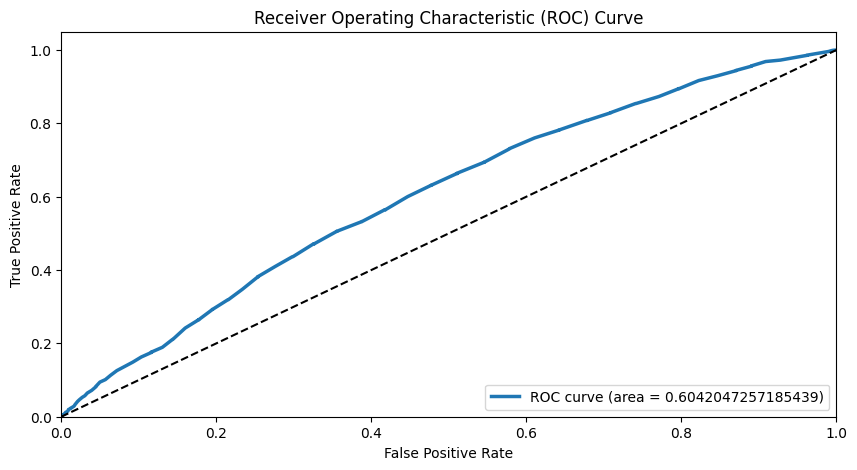

AUC Score of Baseline Model is 0.6042


In [14]:
baseline_RF_roc_auc = evaluation.plot_roc(model=baseline_RFClassifier,
                                        y_test=y_val,
                                        features=X_val)

print(f'AUC Score of Baseline Model is {round(baseline_RF_roc_auc, 4)}')

<div class="alert alert-info" style="background-color:#63A6A2; color:white; padding:0px 10px; border-radius:5px;">
<h5 style='margin:10px 5px'>
1.3. LGBM Classifier
</h5>
</div>

In [4]:
# Try with another classifier
baseline_LGBClassifier = LGBMClassifier(random_state=SEED, class_weight='balanced')
# Training
baseline_LGBClassifier.fit(X=X_train, y=y_train)

NameError: name 'LGBMClassifier' is not defined

In [16]:
# Save model to a file pkl
joblib.dump(baseline_LGBClassifier, '../model/baseline_LGBClassifier.pkl')
baseline_LGBClassifier = joblib.load('../model/baseline_LGBClassifier.pkl')
# Prediction
lgb_pred = baseline_LGBClassifier.predict(X=X_val)

In [17]:
lgb_metrics = evaluation.get_performance(predictions=lgb_pred,
                                               y_test=y_val)

Model Performance metrics:
------------------------------
Accuracy: 0.5886
Precision: 0.3359
Recall: 0.6243
F1 Score: 0.4368

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.82      0.58      0.68      5956
         1.0       0.34      0.62      0.44      2044

    accuracy                           0.59      8000
   macro avg       0.58      0.60      0.56      8000
weighted avg       0.69      0.59      0.61      8000


Prediction Confusion Matrix:
------------------------------
      0     1
0  3433  2523
1   768  1276


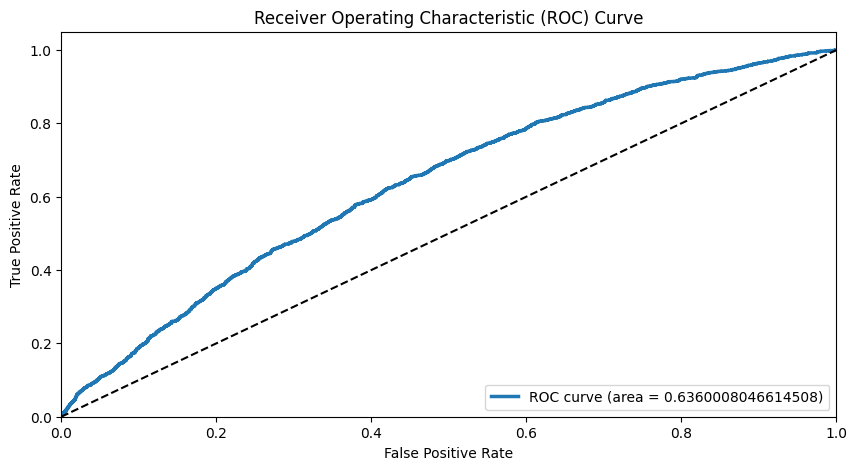

In [18]:
lgb_auc_score = evaluation.plot_roc(model=baseline_LGBClassifier,
                                          y_test=y_val,
                                          features=X_val)

<div class="alert alert-info" style="background-color:#63A6A2; color:white; padding:0px 10px; border-radius:5px;">
<h5 style='margin:10px 5px'>
1.4. Hyperparameter Optimization - Randomized Search CV - LGBM Classifier
</h5>
</div>

In [18]:
# Hyperparameter Optimization
# Parameters
params = {
    'num_leaves'     : [30, 40, 50, 60, 70, 80, 90, 100],
    'num_iterations' : [100, 200, 300, 400, 500],
    'learning_rate'  : [0.1, 0.01, 0.001, 0.0001]
}
# Set RandomizedSearchCV
baseline_best_LGBClassifier = RandomizedSearchCV(estimator=baseline_LGBClassifier,
                                  param_distributions=params,
                                  scoring='accuracy',
                                  n_iter=20)

In [19]:
# Train
lgb_search = baseline_best_LGBClassifier.fit(X=X_train, y=y_train)

In [20]:
# Save model to a file pkl
joblib.dump(lgb_search, '../model/baseline_best_LGBClassifier.pkl')
baseline_best_LGBClassifier = joblib.load('../model/baseline_LGBClassifier.pkl')

In [22]:
lgb_search.best_params_

{'num_leaves': 60, 'num_iterations': 500, 'learning_rate': 0.1}

In [23]:
best_lgb_clf_pred = baseline_best_LGBClassifier.predict(X=X_val)

In [24]:
best_lgb_clf_metrics = evaluation.get_performance(
    predictions=best_lgb_clf_pred, y_test=y_val)

Model Performance metrics:
------------------------------
Accuracy: 0.5886
Precision: 0.3359
Recall: 0.6243
F1 Score: 0.4368

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.82      0.58      0.68      5956
         1.0       0.34      0.62      0.44      2044

    accuracy                           0.59      8000
   macro avg       0.58      0.60      0.56      8000
weighted avg       0.69      0.59      0.61      8000


Prediction Confusion Matrix:
------------------------------
      0     1
0  3433  2523
1   768  1276


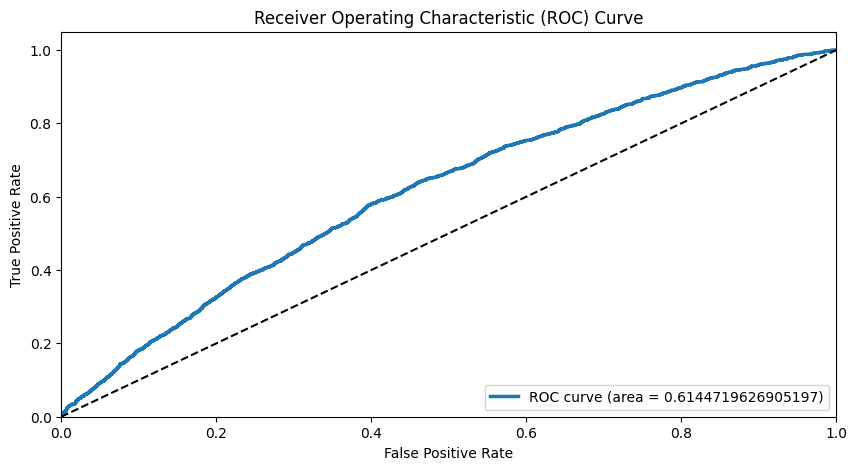

In [39]:
best_lgb_auc_score = evaluation.plot_roc(model=baseline_best_LGBClassifier,
                                               y_test=y_val,
                                               features=X_val)

<div class="alert alert-info" style="background-color:#63A6A2; color:white; padding:0px 10px; border-radius:5px;">
<h5 style='margin:10px 5px'>
1.5. XGB Classifier
</h5>
</div>

In [25]:
# Define model
baseline_XGBClassifier = xgb.XGBClassifier(
                            #tree_method='gpu_hist',
                            tree_method='hist',
                            max_depth=10,
                            eta=0.5,
                            objective='binary:logistic',
                            #gpu_id='0',
                            gpu_id='-1',
                            eval_metric='auc',
                            seed=SEED)
# Train model
baseline_XGBClassifier.fit(X=X_train, y=y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.5,
              eval_metric='auc', gamma=0, gpu_id='-1', grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.5, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, ...)

In [26]:
# Save model to a file pkl
joblib.dump(baseline_XGBClassifier, '../model/baseline_XGBClassifier.pkl')
baseline_XGBClassifier = joblib.load('../model/baseline_XGBClassifier.pkl')
# Prediction
xgb_pred = baseline_XGBClassifier.predict(X=X_val)

In [27]:
best_lgb_clf_metrics = evaluation.get_performance(
    predictions=xgb_pred, y_test=y_val)

Model Performance metrics:
------------------------------
Accuracy: 0.7088
Precision: 0.3526
Recall: 0.1673
F1 Score: 0.2269

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.76      0.89      0.82      5956
         1.0       0.35      0.17      0.23      2044

    accuracy                           0.71      8000
   macro avg       0.56      0.53      0.52      8000
weighted avg       0.65      0.71      0.67      8000


Prediction Confusion Matrix:
------------------------------
      0    1
0  5328  628
1  1702  342


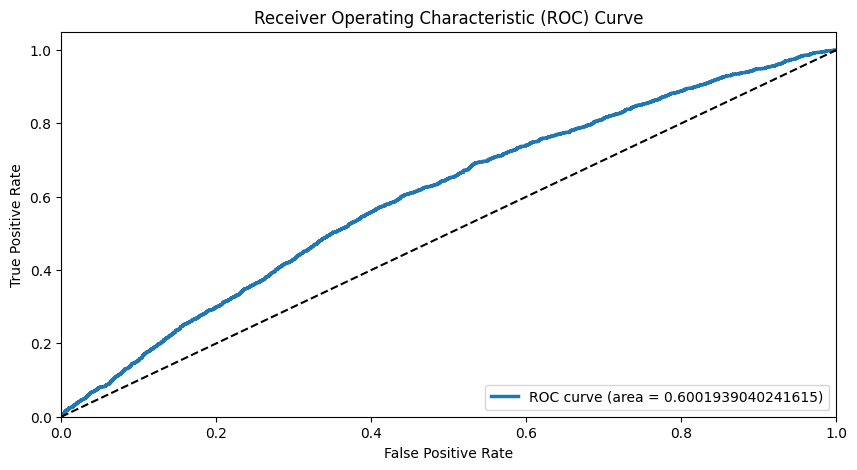

In [30]:
xgb_auc = evaluation.plot_roc(model=baseline_XGBClassifier,
                                    y_test=y_val,
                                    features=X_val)

<div class="alert alert-info" style="background-color:#63A6A2; color:white; padding:0px 10px; border-radius:5px;">
<h5 style='margin:10px 5px'>
1.6. Hyperparameter Optimization - Randomized Search CV - XGB Classifier
</h5>
</div>

In [29]:
# Parameters
params = {
    'max_depth'       : [3, 6, 10, 20, 30, 50, 100],
    'eta'             : [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    'scale_pos_weight': [1, 1.5, 2, 2.5, 3, 3.5]
}
# Set RandomizedSearchCV
baseline_best_XGBClassifier = RandomizedSearchCV(estimator=baseline_XGBClassifier,
                                  param_distributions=params,
                                  scoring='recall',
                                  n_iter=64,
                                  random_state=SEED)

In [30]:
# Train
xgb_search = baseline_best_XGBClassifier.fit(X=X_train, y=y_train)

In [31]:
# Save model to a file pkl
joblib.dump(baseline_best_XGBClassifier, '../model/baseline_best_XGBClassifier.pkl')
baseline_best_XGBClassifier = joblib.load('../model/baseline_best_XGBClassifier.pkl')

In [32]:
xgb_search.best_params_

{'scale_pos_weight': 3, 'max_depth': 3, 'eta': 0.1}

In [33]:
best_xgb_clf_pred = baseline_best_XGBClassifier.predict(X=X_val)

In [34]:
best_xgb_clf_metrics = evaluation.get_performance(
    predictions=best_xgb_clf_pred, y_test=y_val)

Model Performance metrics:
------------------------------
Accuracy: 0.5609
Precision: 0.3225
Recall: 0.6526
F1 Score: 0.4316

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.82      0.53      0.64      5956
         1.0       0.32      0.65      0.43      2044

    accuracy                           0.56      8000
   macro avg       0.57      0.59      0.54      8000
weighted avg       0.69      0.56      0.59      8000


Prediction Confusion Matrix:
------------------------------
      0     1
0  3153  2803
1   710  1334


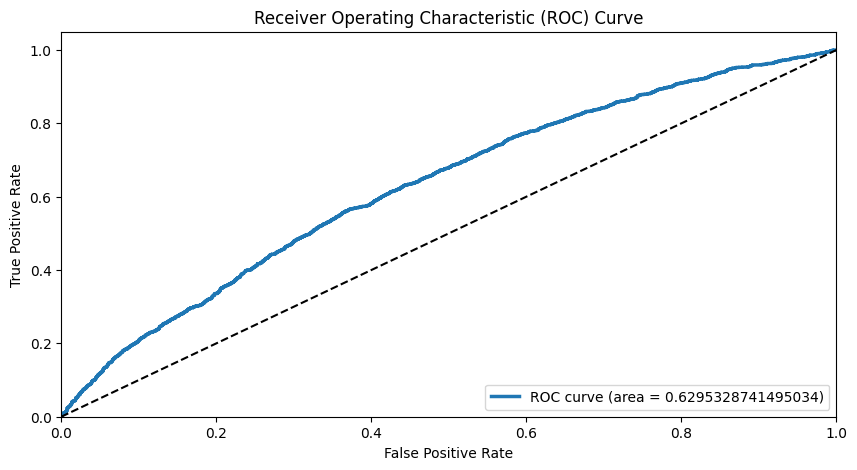

In [35]:
best_xgb_auc_score = evaluation.plot_roc(model=baseline_best_XGBClassifier,
                                               y_test=y_val,
                                               features=X_val)

<div class="alert alert-info" style="background-color:#63A6A2; color:white; padding:0px 10px; border-radius:5px;">
<h5 style='margin:10px 5px'>
1.7. Summary of model Result
</h5>
</div>

#### Validation Data

<table>
<tr>
<td style="background-color: #0080FF">Model</td>
<td style="background-color: #0080FF">ROC-AUC</td>
<td style="background-color: #0080FF">Accuracy</td>
<td style="background-color: #0080FF">Precision</td>
<td style="background-color: #0080FF">ReCall</td>
<td style="background-color: #0080FF">F1</td>
</tr>

<tr>
<td>Random Fores Classifier</td>
<td>0.60</td>
<td>0.73</td>
<td>0.39</td>
<td style="background-color: #F34444">0.06</td>
<td>0.11</td>
</tr>

<tr>
<td>LGB Classifier</td>
<td>0.63</td>
<td>0.59</td>
<td>0.33</td>
<td>0.62</td>
<td>0.44</td>
</tr>

<tr>
<td>LGB Best Classifier</td>
<td>0.61</td>
<td>0.59</td>
<td>0.33</td>
<td>0.62</td>
<td>0.44</td>
</tr>

<tr>
<td>XGB Classifier</td>
<td>0.60</td>
<td>0.70</td>
<td>0.35</td>
<td style="background-color: #F34444">0.16</td>
<td>0.22</td>
</tr>

<tr>
<td>XGB Best Parameters</td>
<td>0.62</td>
<td>0.56</td>
<td>0.32</td>
<td>0.65</td>
<td>0.43</td>
</tr>

</table>

#### Test Data

<table>
<tr>
<td style="background-color: #0080FF">Model</td>
<td style="background-color: #0080FF">ROC-AUC</td>
<td style="background-color: #0080FF">Accuracy</td>
<td style="background-color: #0080FF">Precision</td>
<td style="background-color: #0080FF">ReCall</td>
<td style="background-color: #0080FF">F1</td>
</tr>

<tr>
<td>Random Fores Classifier</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>

<tr>
<td>LGB Classifier</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>

<tr>
<td>LGB Best Classifier</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>

<tr>
<td>XGB Classifier</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>

<tr>
<td>XGB Best Parameters</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>

</table>